In [ ]:
## Crime Prediction

Dataset - https://data.baltimorecity.gov/Public-Safety/BPD-Part-1-Victim-Based-Crime-Data/wsfq-mvij

In [240]:
%matplotlib inline
import pandas as pd

import numpy as np
import matplotlib as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn import linear_model, model_selection, preprocessing, metrics, datasets
from sklearn.multiclass import OneVsRestClassifier
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score

In [2]:
# The dataset
pc=pd.read_csv("BPD_Victim.csv")
pc.sample(50).head(10)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
122670,06/27/2015,00:36:00,4B,3900 FERNDALE AVE,AGG. ASSAULT,I,KNIFE,622.0,NORTHWESTERN,Howard Park,-76.69680,39.33846,"(39.3384600000, -76.6968000000)",ROW/TOWNHO,1
77062,06/05/2016,16:00:00,6D,2000 E FAYETTE ST,LARCENY FROM AUTO,O,NaN,212.0,EASTERN,Butcher's Hill,-76.58820,39.29413,"(39.2941300000, -76.5882000000)",PARKING LO,1
3025,11/08/2017,19:30:00,3B,1700 INGRAM RD,ROBBERY - STREET,O,NaN,415.0,NORTHEASTERN,Perring Loch,-76.58376,39.35114,"(39.3511400000, -76.5837600000)",ALLEY,1
56897,10/23/2016,23:00:00,7A,1600 CLIFTON AVE,AUTO THEFT,O,NaN,733.0,WESTERN,Penn North,-76.64573,39.31228,"(39.3122800000, -76.6457300000)",STREET,1
38716,03/02/2017,09:30:00,6C,0 S PACA ST,LARCENY,NaN,NaN,121.0,CENTRAL,University Of Maryland,-76.62225,39.28833,"(39.2883300000, -76.6222500000)",NaN,1
191572,12/25/2013,02:00:00,5D,4200 SHANNON DR,BURGLARY,O,NaN,433.0,NORTHEASTERN,Orchard Ridge,-76.55541,39.31673,"(39.3167300000, -76.5554100000)",MINI STORA,1
197866,11/07/2013,20:40:00,6C,2400 FREDERICK AV,LARCENY,I,NaN,841.0,SOUTHWESTERN,Millhill,-76.65583,39.28342,"(39.2834200000, -76.6558300000)",OTHER - IN,1
220518,06/05/2013,12:00:00,5A,400 HAZLETT AV,BURGLARY,I,NaN,833.0,SOUTHWESTERN,Beechfield,-76.69812,39.27836,"(39.2783600000, -76.6981200000)",SINGLE HOU,1
133498,04/15/2015,12:00:00,6E,5400 PARK HEIGHTS AVE,LARCENY,I,NaN,633.0,NORTHWESTERN,Arlington,-76.68143,39.35061,"(39.3506100000, -76.6814300000)",OTHER - IN,1
266587,06/22/2012,22:45:00,4B,5200 FRANKFORD AV,AGG. ASSAULT,I,KNIFE,443.0,NORTHEASTERN,Frankford,-76.54112,39.32628,"(39.3262800000, -76.5411200000)",APT/CONDO,1


In [3]:
pc.columns

Index(['CrimeDate', 'CrimeTime', 'CrimeCode', 'Location', 'Description',
       'Inside/Outside', 'Weapon', 'Post', 'District', 'Neighborhood',
       'Longitude', 'Latitude', 'Location 1', 'Premise', 'Total Incidents'],
      dtype='object')

In [4]:
pc.Description.unique()

array(['COMMON ASSAULT', 'LARCENY', 'ROBBERY - STREET', 'AGG. ASSAULT',
       'LARCENY FROM AUTO', 'HOMICIDE', 'BURGLARY', 'AUTO THEFT',
       'ROBBERY - RESIDENCE', 'ROBBERY - COMMERCIAL',
       'ROBBERY - CARJACKING', 'ASSAULT BY THREAT', 'SHOOTING', 'RAPE',
       'ARSON'], dtype=object)

In [5]:
#Get only outside crimes

pc = pc.loc[pc['Inside/Outside'] == 'O']

In [6]:
time_desc = pc[['CrimeDate', 'CrimeTime', 'Description']]
time_desc.columns
time_desc['CrimeTime'] = time_desc['CrimeDate'].map(str) + ' ' + time_desc['CrimeTime']
del time_desc['CrimeDate']
time_desc.head()

/home/payal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CrimeTime,Description
3,12/02/2017 21:29:00,ROBBERY - STREET
7,12/02/2017 21:10:00,COMMON ASSAULT
8,12/02/2017 21:09:00,AGG. ASSAULT
11,12/02/2017 20:30:00,ROBBERY - STREET
15,12/02/2017 20:00:00,ROBBERY - STREET


In [7]:
time_desc['CrimeTime'] = pd.to_datetime(time_desc['CrimeTime'])

/home/payal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
time_desc.columns

Index(['CrimeTime', 'Description'], dtype='object')

In [9]:
time_desc.dtypes

CrimeTime      datetime64[ns]
Description            object
dtype: object

In [10]:
time_desc['hour'] = time_desc.CrimeTime.apply(lambda x : x.hour)

/home/payal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
time_desc['year'] = time_desc.CrimeTime.apply(lambda x : x.year)

/home/payal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
time_desc.head()

,CrimeTime,Description,hour,year
3,2017-12-02 21:29:00,ROBBERY - STREET,21,2017
7,2017-12-02 21:10:00,COMMON ASSAULT,21,2017
8,2017-12-02 21:09:00,AGG. ASSAULT,21,2017
11,2017-12-02 20:30:00,ROBBERY - STREET,20,2017
15,2017-12-02 20:00:00,ROBBERY - STREET,20,2017


In [45]:
# number of crimes per year color coded by crime type - line graph - one line per crime type

by_year = time_desc.groupby(['year', 'Description']).count().reset_index()
by_year['count'] = by_year['CrimeTime']
del by_year['CrimeTime']
del by_year['hour']
by_year.head()

,year,Description,count
0,2012,AGG. ASSAULT,2270
1,2012,ARSON,114
2,2012,ASSAULT BY THREAT,131
3,2012,AUTO THEFT,3563
4,2012,BURGLARY,352


In [62]:
by_year.dtypes

year            int64
Description    object
count           int64
dtype: object

In [74]:
crime_type = time_desc['Description'].unique().tolist()


In [48]:
import plotly.graph_objs as bp
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly.offline as po
init_notebook_mode(connected=True)

In [154]:
import sklearn.preprocessing as sk

le = sk.LabelEncoder()

by_year['Description'] = le.fit_transform(by_year['Description'])
#list(le.inverse_transform(by_year['Description']))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12]

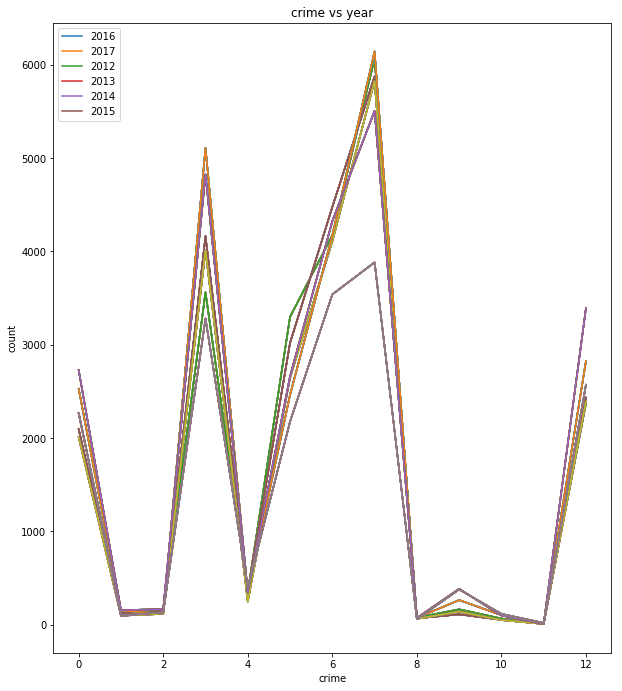

In [112]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))

year = by_year['year'].tolist()
crime_type = time_desc['Description'].unique().tolist()

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('crime vs year')
ax.set_xlabel('crime')
ax.set_ylabel('count')


for i in year:
    x = by_year.loc[by_year['year'] == i]['Description'].tolist()
    y = by_year.loc[by_year['year'] == i]['count'].tolist()
    plt.plot(x, y)

print()
plt.legend(set(year), loc='upper left')
plt.show()

In [124]:
# number of crimes per hour color coded by crime type - line graph - one line per crime type

by_hour = time_desc.groupby(['hour', 'Description']).count().reset_index()
by_hour['count'] = by_hour['CrimeTime']
del by_hour['CrimeTime']
del by_hour['year']
by_hour.head()



,hour,Description,count
0,0,AGG. ASSAULT,815
1,0,ARSON,81
2,0,ASSAULT BY THREAT,19
3,0,AUTO THEFT,1365
4,0,BURGLARY,143


In [128]:
by_hour['Description'] = le.fit_transform(by_hour['Description'])

In [157]:
t = le.fit_transform(time_desc['Description'])

tt = le.inverse_transform(t)
#by_hour['Description'].tolist()
tt

array(['ROBBERY - STREET', 'COMMON ASSAULT', 'AGG. ASSAULT', ...,
       'AUTO THEFT', 'LARCENY', 'LARCENY'], dtype=object)

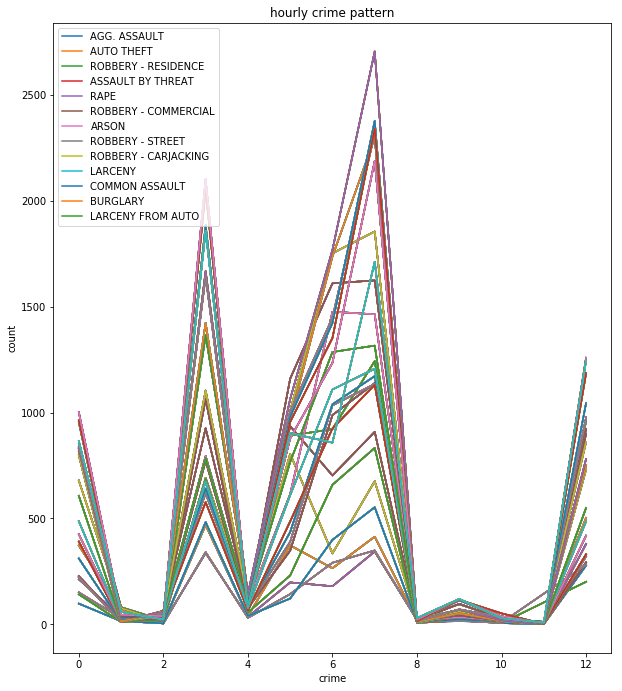

In [135]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))

hour = by_hour['hour'].tolist()
crime_type = time_desc['Description'].unique().tolist()

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('hourly crime pattern')
ax.set_xlabel('crime')
ax.set_ylabel('count')


for i in hour:
    x = by_hour.loc[by_hour['hour'] == i]['Description'].tolist()
    y = by_hour.loc[by_hour['hour'] == i]['count'].tolist()
    plt.plot(x, y)

print()
plt.legend(set(hour), loc='upper left')
plt.show()

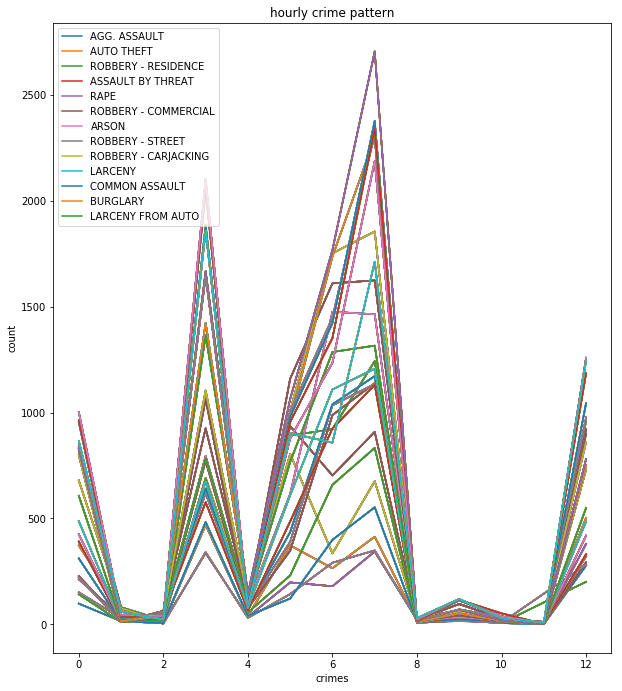

In [158]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,10))

hour = by_hour['hour'].tolist()
crime_type = by_hour['Description'].unique().tolist()

#print(crime_type)

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title('hourly crime pattern')
ax.set_xlabel('crimes')
ax.set_ylabel('count')


for i in hour:
    #print(i)
    x = by_hour.loc[by_hour['hour'] == i]['Description'].tolist()
    y = by_hour.loc[by_hour['hour'] == i]['count'].tolist()
    plt.plot(x, y)

plt.legend(set(tt), loc='upper left')
plt.show()

In [166]:
tt[12]

'LARCENY FROM AUTO'

Auto larceny varies a lot by year, highest in 2013

## k-NN

In [151]:
time_desc.head()
time_desc.groupby('year').count()

,CrimeTime,Description,hour
year,,,
2012,22666,22666,22666
2013,22933,22933,22933
2014,21731,21731,21731
2015,24310,24310,24310
2016,24690,24690,24690
2017,18923,18923,18923


In [ ]:
# Which crimes happen at night typically? Classify based on time



In [167]:
by_hour.head()

,hour,Description,count
0,0,0,815
1,0,1,81
2,0,2,19
3,0,3,1365
4,0,4,143


In [169]:
pc.dtypes

CrimeDate           object
CrimeTime           object
CrimeCode           object
Location            object
Description         object
Inside/Outside      object
Weapon              object
Post               float64
District            object
Neighborhood        object
Longitude          float64
Latitude           float64
Location 1          object
Premise             object
Total Incidents      int64
dtype: object

## Preprocess Crime data for Classification


In [207]:
pc.columns
pc.shape

pp = pc.copy()

#preprocessing.LabelEncoder().fit(pp['Description'])
dd = preprocessing.LabelEncoder().fit_transform(pp['Description'])
#w = preprocessing.LabelEncoder().fit_transform(pp['Weapon'])
pp['Weapon'].fillna('unknown')
w = preprocessing.LabelEncoder().fit_transform(pp['Weapon'].astype(str))
w

array([0, 1, 3, ..., 4, 4, 4])

In [311]:
# predict hour based on crime description

model = LinearDiscriminantAnalysis()

pp = pc.copy()

pp.fillna('unknown')

le = preprocessing.LabelEncoder()
pp['Description'] = le.fit_transform(pp['Description'])
pp['CrimeCode'] = le.fit_transform(pp['CrimeCode'].astype(str))
pp['Weapon'] = le.fit_transform(pp['Weapon'].astype(str))
pp['Neighborhood'] = le.fit_transform(pp['Neighborhood'].astype(str))
pp['Inside/Outside'] = le.fit_transform(pp['Inside/Outside'].astype(str))
pp['Post'] = le.fit_transform(pp['Post'].astype(str))
pp['District'] = le.fit_transform(pp['District'].astype(str))
pp['Premise'] = le.fit_transform(pp['Premise'].astype(str))


In [312]:

pp['CrimeTime'] = pd.to_datetime(pp['CrimeTime'])

pp['CrimeTime'] = pp.CrimeTime.apply(lambda x : x.hour)

pp.dtypes
#pp.CrimeTime.unique()

CrimeDate           object
CrimeTime            int64
CrimeCode            int64
Location            object
Description          int64
Inside/Outside       int64
Weapon               int64
Post                 int64
District             int64
Neighborhood         int64
Longitude          float64
Latitude           float64
Location 1          object
Premise              int64
Total Incidents      int64
dtype: object

In [268]:
np.seterr(divide=None, invalid=None)

X = pp[['CrimeCode', 'CrimeTime', 'Neighborhood', 'Weapon', 'Inside/Outside', 'District']]
Y = pp['Premise']

Z = model.fit(X, Y)

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



In [269]:
model.score(X, Y)

0.77767591107036438

In [284]:
pp.head(20)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
3,12/02/2017,21,2,4400 SPRINGDALE AVE,12,0,0,106,4,120,-76.69304,39.32785,"(39.3278500000, -76.6930400000)",31,1
7,12/02/2017,21,35,2400 S HANOVER ST,5,0,1,173,6,236,-76.61466,39.26307,"(39.2630700000, -76.6146600000)",31,1
8,12/02/2017,21,33,2300 LIBERTY HEIGHTS AVE,0,0,3,129,8,161,-76.65345,39.31850,"(39.3185000000, -76.6534500000)",31,1
11,12/02/2017,20,2,3400 ROSEDALE RD,12,0,0,118,4,5,-76.66747,39.32333,"(39.3233300000, -76.6674700000)",31,1
15,12/02/2017,20,2,AV & N CAREY ST,12,0,0,121,8,108,-76.63851,39.29544,"(39.2954400000, -76.6385100000)",31,1
16,12/02/2017,20,46,2800 PULASKI HWY,7,0,4,24,5,151,-76.57689,39.29505,"(39.2950500000, -76.5768900000)",31,1
20,12/02/2017,19,2,2900 W NORTH AVE,12,0,0,137,7,253,-76.66604,39.30919,"(39.3091900000, -76.6660400000)",31,1
21,12/02/2017,19,2,1900 BLOOMINGDALE RD,12,0,0,137,7,253,-76.67123,39.30899,"(39.3089900000, -76.6712300000)",31,1
29,12/02/2017,17,35,5600 LOCH RAVEN BLVD,5,0,1,57,2,141,-76.58856,39.35952,"(39.3595200000, -76.5885600000)",21,1
30,10/25/2017,16,46,NaN,7,0,4,5,0,278,NaN,NaN,NaN,31,1


In [283]:
model.predict([[35, 12, 120, 1, 1, 4]])

pp.groupby

array([31])

In [280]:
le.inverse_transform(pp.Premise.unique().tolist())[31]

'NIGHT DEPO'

In [278]:
pc.Premise.unique()

array(['STREET', 'PARKING LO', 'GAS STATIO', 'YARD', 'PARK', 'ALLEY',
       'BUS/AUTO', 'OTHER - OU', 'PLAYGROUND', 'YARD/BUSIN', 'SHED/GARAG',
       'DRIVEWAY', 'PORCH/DECK', 'BUS. PARK', 'SCHOOL PLA', 'CAB',
       'STADIUM', 'MINI STORA', 'INNER HARB', 'ATM MACHIN', 'HOUSE UNDE',
       'BUS.  STOR', 'PIZZA/OTHE', 'RACE TRACK', 'CEMETERY', 'BOX CARS/C',
       'BOAT/SHIP', 'MAILBOX-ST', 'SUBWAY', 'BRIDGE-PIE', 'BOAT YARD',
       'NIGHT DEPO', 'RAILROAD C', 'UTILITIES-', 'MTA LOT', 'SKYWALK'], dtype=object)

In [310]:
pp.shape

pp_1 = pp.iloc[:125000, :]
pp_2 = pp.iloc[125000:, :]


In [385]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with

#pp_1 = pp.iloc[:200, :]

pp_1 = pp.copy()
X = pp_1[['CrimeCode', 'CrimeTime', 'District', 'Neighborhood', 'Premise', 'Inside/Outside']]
y = pp_1['Weapon']

class_names = pp_1.Premise.unique().tolist()

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
classifier = LinearDiscriminantAnalysis()
y_pred = classifier.fit(X_train, y_train).predict(X_test)


y_pred

Automatically created module for IPython interactive environment


/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



array([4, 4, 4, ..., 0, 4, 4])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [378]:
type(y_test)

pandas.core.series.Series

In [386]:
#classifier.score(X_test,pd.DataFrame(y_pred))
from sklearn.model_selection import cross_val_score

y_test.reshape(-1, 1)
pd.DataFrame(y_pred.reshape(-1, 1))

cross_val_score(classifier, X, y, scoring='neg_log_loss')

/home/payal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



array([-0.81, -0.77, -0.79])

In [387]:
cross_val_score(model, X, y, scoring='accuracy')

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.

/home/payal/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning:

Variables are collinear.



array([ 0.7 ,  0.71,  0.71])

In [388]:
# MLP Classifier

from sklearn.neural_network import MLPClassifier

#X = pp[['Description']]
#Y = pp['CrimeTime']

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

y_pred = clf.fit(X_train, y_train).predict(X_test)

In [389]:
clf.score(X, y)

0.84103125254153333

In [390]:
cross_val_score(clf, X, y, scoring='accuracy')

array([ 0.84,  0.85,  0.8 ])

## Neural networks provide better accuracy of predicting weapon vs LDA